In [4]:
# read data
import os

imdb_dir = '/home/yahu/demos/python/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name,fname)) as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %d unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

Found 88582 unique tokens.


Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [6]:
glove_dir = '/home/yahu/demos/python/models/glove'

embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=12,
                    validation_data=(x_val, y_val))

In [ ]:
model.save_weights('./models/pre_trained_glove_model.h5')

In [13]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def draw_acc_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
    plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
    plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

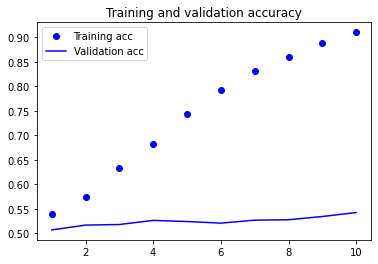

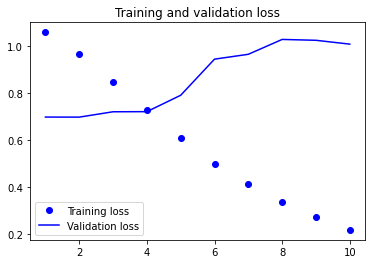

In [14]:
draw_acc_and_loss(history)

In [15]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name, fname)) as f:
                texts.append(f.read())
        if label_type == 'neg':
            labels.append(0)
        else:
            labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [16]:
model.load_weights('pre_trained_glove_model.h5')
print(model.evaluate(x_test, y_test))

  1/782 [..............................] - ETA: 0s - loss: 0.7206 - acc: 0.7500

  3/782 [..............................] - ETA: 16s - loss: 0.6463 - acc: 0.7396

  6/782 [..............................] - ETA: 16s - loss: 0.5862 - acc: 0.7396

  8/782 [..............................] - ETA: 19s - loss: 0.5480 - acc: 0.7656

 10/782 [..............................] - ETA: 19s - loss: 0.5617 - acc: 0.7531

 13/782 [..............................] - ETA: 18s - loss: 0.5590 - acc: 0.7548

 15/782 [..............................] - ETA: 20s - loss: 0.5762 - acc: 0.7417

 17/782 [..............................] - ETA: 20s - loss: 0.5969 - acc: 0.7298

 19/782 [..............................] - ETA: 20s - loss: 0.5836 - acc: 0.7319

 22/782 [..............................] - ETA: 19s - loss: 0.5879 - acc: 0.7259

 24/782 [..............................] - ETA: 20s - loss: 0.5879 - acc: 0.7240

 26/782 [..............................] - ETA: 20s - loss: 0.5783 - acc: 0.7308

 28/782 [>.............................] - ETA: 20s - loss: 0.5814 - acc: 0.7266

 30/782 [>.............................] - ETA: 20s - loss: 0.5837 - acc: 0.7240

 32/782 [>.............................] - ETA: 20s - loss: 0.5855 - acc: 0.7227

 34/782 [>.............................] - ETA: 20s - loss: 0.5890 - acc: 0.7197

 36/782 [>.............................] - ETA: 20s - loss: 0.5912 - acc: 0.7240

 38/782 [>.............................] - ETA: 20s - loss: 0.5922 - acc: 0.7196

 40/782 [>.............................] - ETA: 20s - loss: 0.5954 - acc: 0.7180

 42/782 [>.............................] - ETA: 20s - loss: 0.5972 - acc: 0.7195

 44/782 [>.............................] - ETA: 20s - loss: 0.6060 - acc: 0.7131

 46/782 [>.............................] - ETA: 21s - loss: 0.6042 - acc: 0.7140

 48/782 [>.............................] - ETA: 20s - loss: 0.6006 - acc: 0.7155

 49/782 [>.............................] - ETA: 21s - loss: 0.6014 - acc: 0.7149

 51/782 [>.............................] - ETA: 21s - loss: 0.6049 - acc: 0.7138

 53/782 [=>............................] - ETA: 21s - loss: 0.6053 - acc: 0.7146

 55/782 [=>............................] - ETA: 21s - loss: 0.6118 - acc: 0.7142

 57/782 [=>............................] - ETA: 21s - loss: 0.6153 - acc: 0.7133

 59/782 [=>............................] - ETA: 21s - loss: 0.6208 - acc: 0.7097

 60/782 [=>............................] - ETA: 22s - loss: 0.6211 - acc: 0.7099

 61/782 [=>............................] - ETA: 22s - loss: 0.6244 - acc: 0.7080

 63/782 [=>............................] - ETA: 22s - loss: 0.6282 - acc: 0.7049

 65/782 [=>............................] - ETA: 22s - loss: 0.6237 - acc: 0.7058

 67/782 [=>............................] - ETA: 22s - loss: 0.6244 - acc: 0.7052

 69/782 [=>............................] - ETA: 22s - loss: 0.6277 - acc: 0.7034

 71/782 [=>............................] - ETA: 22s - loss: 0.6260 - acc: 0.7038

 73/782 [=>............................] - ETA: 22s - loss: 0.6290 - acc: 0.7021

 75/782 [=>............................] - ETA: 23s - loss: 0.6280 - acc: 0.7008

 77/782 [=>............................] - ETA: 22s - loss: 0.6296 - acc: 0.7001

 79/782 [==>...........................] - ETA: 22s - loss: 0.6285 - acc: 0.7021

 81/782 [==>...........................] - ETA: 22s - loss: 0.6263 - acc: 0.7041

 83/782 [==>...........................] - ETA: 22s - loss: 0.6267 - acc: 0.7037

 84/782 [==>...........................] - ETA: 22s - loss: 0.6271 - acc: 0.7031

 86/782 [==>...........................] - ETA: 22s - loss: 0.6250 - acc: 0.7049

 88/782 [==>...........................] - ETA: 22s - loss: 0.6260 - acc: 0.7060

 90/782 [==>...........................] - ETA: 22s - loss: 0.6243 - acc: 0.7042

 92/782 [==>...........................] - ETA: 22s - loss: 0.6224 - acc: 0.7052

 94/782 [==>...........................] - ETA: 22s - loss: 0.6233 - acc: 0.7058

 96/782 [==>...........................] - ETA: 22s - loss: 0.6199 - acc: 0.7064

 98/782 [==>...........................] - ETA: 22s - loss: 0.6201 - acc: 0.7057

100/782 [==>...........................] - ETA: 22s - loss: 0.6217 - acc: 0.7044

102/782 [==>...........................] - ETA: 21s - loss: 0.6215 - acc: 0.7050

104/782 [==>...........................] - ETA: 21s - loss: 0.6182 - acc: 0.7052

105/782 [===>..........................] - ETA: 22s - loss: 0.6175 - acc: 0.7060

107/782 [===>..........................] - ETA: 22s - loss: 0.6202 - acc: 0.7059

109/782 [===>..........................] - ETA: 22s - loss: 0.6225 - acc: 0.7056

111/782 [===>..........................] - ETA: 22s - loss: 0.6202 - acc: 0.7064

113/782 [===>..........................] - ETA: 21s - loss: 0.6182 - acc: 0.7077

115/782 [===>..........................] - ETA: 21s - loss: 0.6176 - acc: 0.7082

117/782 [===>..........................] - ETA: 21s - loss: 0.6180 - acc: 0.7081

119/782 [===>..........................] - ETA: 21s - loss: 0.6168 - acc: 0.7093

122/782 [===>..........................] - ETA: 21s - loss: 0.6201 - acc: 0.7077

124/782 [===>..........................] - ETA: 21s - loss: 0.6231 - acc: 0.7069

126/782 [===>..........................] - ETA: 21s - loss: 0.6257 - acc: 0.7061

128/782 [===>..........................] - ETA: 21s - loss: 0.6267 - acc: 0.7053

130/782 [===>..........................] - ETA: 21s - loss: 0.6245 - acc: 0.7060

132/782 [====>.........................] - ETA: 21s - loss: 0.6284 - acc: 0.7045

134/782 [====>.........................] - ETA: 20s - loss: 0.6287 - acc: 0.7036

136/782 [====>.........................] - ETA: 20s - loss: 0.6270 - acc: 0.7040

139/782 [====>.........................] - ETA: 20s - loss: 0.6314 - acc: 0.7019

142/782 [====>.........................] - ETA: 20s - loss: 0.6283 - acc: 0.7042

144/782 [====>.........................] - ETA: 20s - loss: 0.6297 - acc: 0.7038

147/782 [====>.........................] - ETA: 20s - loss: 0.6315 - acc: 0.7032

149/782 [====>.........................] - ETA: 20s - loss: 0.6319 - acc: 0.7032

151/782 [====>.........................] - ETA: 20s - loss: 0.6312 - acc: 0.7034

152/782 [====>.........................] - ETA: 20s - loss: 0.6307 - acc: 0.7039

154/782 [====>.........................] - ETA: 20s - loss: 0.6298 - acc: 0.7039

157/782 [=====>........................] - ETA: 19s - loss: 0.6330 - acc: 0.7034

159/782 [=====>........................] - ETA: 19s - loss: 0.6341 - acc: 0.7032

161/782 [=====>........................] - ETA: 19s - loss: 0.6336 - acc: 0.7036

163/782 [=====>........................] - ETA: 19s - loss: 0.6337 - acc: 0.7028

165/782 [=====>........................] - ETA: 19s - loss: 0.6330 - acc: 0.7030

167/782 [=====>........................] - ETA: 19s - loss: 0.6312 - acc: 0.7043

169/782 [=====>........................] - ETA: 19s - loss: 0.6333 - acc: 0.7027

171/782 [=====>........................] - ETA: 19s - loss: 0.6333 - acc: 0.7032

173/782 [=====>........................] - ETA: 19s - loss: 0.6325 - acc: 0.7039

175/782 [=====>........................] - ETA: 19s - loss: 0.6334 - acc: 0.7038

177/782 [=====>........................] - ETA: 19s - loss: 0.6341 - acc: 0.7043

179/782 [=====>........................] - ETA: 19s - loss: 0.6367 - acc: 0.7034

181/782 [=====>........................] - ETA: 19s - loss: 0.6375 - acc: 0.7027

183/782 [======>.......................] - ETA: 19s - loss: 0.6376 - acc: 0.7024

185/782 [======>.......................] - ETA: 19s - loss: 0.6386 - acc: 0.7017

187/782 [======>.......................] - ETA: 19s - loss: 0.6370 - acc: 0.7024

189/782 [======>.......................] - ETA: 18s - loss: 0.6372 - acc: 0.7022

191/782 [======>.......................] - ETA: 18s - loss: 0.6376 - acc: 0.7017

193/782 [======>.......................] - ETA: 18s - loss: 0.6371 - acc: 0.7022

195/782 [======>.......................] - ETA: 18s - loss: 0.6371 - acc: 0.7018

197/782 [======>.......................] - ETA: 18s - loss: 0.6375 - acc: 0.7016

199/782 [======>.......................] - ETA: 18s - loss: 0.6408 - acc: 0.6997

201/782 [======>.......................] - ETA: 18s - loss: 0.6407 - acc: 0.7002

202/782 [======>.......................] - ETA: 18s - loss: 0.6415 - acc: 0.7000

204/782 [======>.......................] - ETA: 18s - loss: 0.6423 - acc: 0.7005

207/782 [======>.......................] - ETA: 18s - loss: 0.6427 - acc: 0.7003

209/782 [=======>......................] - ETA: 18s - loss: 0.6424 - acc: 0.7008

212/782 [=======>......................] - ETA: 18s - loss: 0.6406 - acc: 0.7019

214/782 [=======>......................] - ETA: 18s - loss: 0.6404 - acc: 0.7015

216/782 [=======>......................] - ETA: 18s - loss: 0.6408 - acc: 0.7010

218/782 [=======>......................] - ETA: 17s - loss: 0.6398 - acc: 0.7013

220/782 [=======>......................] - ETA: 17s - loss: 0.6393 - acc: 0.7013

222/782 [=======>......................] - ETA: 17s - loss: 0.6378 - acc: 0.7017

224/782 [=======>......................] - ETA: 17s - loss: 0.6374 - acc: 0.7016

226/782 [=======>......................] - ETA: 17s - loss: 0.6368 - acc: 0.7016

228/782 [=======>......................] - ETA: 17s - loss: 0.6361 - acc: 0.7020

230/782 [=======>......................] - ETA: 17s - loss: 0.6351 - acc: 0.7029

232/782 [=======>......................] - ETA: 17s - loss: 0.6350 - acc: 0.7035

234/782 [=======>......................] - ETA: 17s - loss: 0.6367 - acc: 0.7034

236/782 [========>.....................] - ETA: 17s - loss: 0.6385 - acc: 0.7026

238/782 [========>.....................] - ETA: 17s - loss: 0.6370 - acc: 0.7034

240/782 [========>.....................] - ETA: 17s - loss: 0.6362 - acc: 0.7040

242/782 [========>.....................] - ETA: 17s - loss: 0.6361 - acc: 0.7039

244/782 [========>.....................] - ETA: 17s - loss: 0.6368 - acc: 0.7036

246/782 [========>.....................] - ETA: 16s - loss: 0.6374 - acc: 0.7029

248/782 [========>.....................] - ETA: 16s - loss: 0.6368 - acc: 0.7033

250/782 [========>.....................] - ETA: 16s - loss: 0.6371 - acc: 0.7032

252/782 [========>.....................] - ETA: 16s - loss: 0.6370 - acc: 0.7041

254/782 [========>.....................] - ETA: 16s - loss: 0.6373 - acc: 0.7045

256/782 [========>.....................] - ETA: 16s - loss: 0.6384 - acc: 0.7042

258/782 [========>.....................] - ETA: 16s - loss: 0.6385 - acc: 0.7039

260/782 [========>.....................] - ETA: 16s - loss: 0.6395 - acc: 0.7041

262/782 [=========>....................] - ETA: 16s - loss: 0.6386 - acc: 0.7042

264/782 [=========>....................] - ETA: 16s - loss: 0.6380 - acc: 0.7047

266/782 [=========>....................] - ETA: 16s - loss: 0.6372 - acc: 0.7049

268/782 [=========>....................] - ETA: 16s - loss: 0.6381 - acc: 0.7039

270/782 [=========>....................] - ETA: 16s - loss: 0.6389 - acc: 0.7038

272/782 [=========>....................] - ETA: 15s - loss: 0.6385 - acc: 0.7043

274/782 [=========>....................] - ETA: 15s - loss: 0.6373 - acc: 0.7047

276/782 [=========>....................] - ETA: 15s - loss: 0.6358 - acc: 0.7058

278/782 [=========>....................] - ETA: 15s - loss: 0.6356 - acc: 0.7064

280/782 [=========>....................] - ETA: 15s - loss: 0.6367 - acc: 0.7059

282/782 [=========>....................] - ETA: 15s - loss: 0.6361 - acc: 0.7064

284/782 [=========>....................] - ETA: 15s - loss: 0.6363 - acc: 0.7061

286/782 [=========>....................] - ETA: 15s - loss: 0.6362 - acc: 0.7064

288/782 [==========>...................] - ETA: 15s - loss: 0.6364 - acc: 0.7065

291/782 [==========>...................] - ETA: 15s - loss: 0.6369 - acc: 0.7061

293/782 [==========>...................] - ETA: 15s - loss: 0.6368 - acc: 0.7062

295/782 [==========>...................] - ETA: 15s - loss: 0.6357 - acc: 0.7067

298/782 [==========>...................] - ETA: 14s - loss: 0.6356 - acc: 0.7065

300/782 [==========>...................] - ETA: 14s - loss: 0.6352 - acc: 0.7065

302/782 [==========>...................] - ETA: 14s - loss: 0.6349 - acc: 0.7064

304/782 [==========>...................] - ETA: 14s - loss: 0.6338 - acc: 0.7069

306/782 [==========>...................] - ETA: 14s - loss: 0.6330 - acc: 0.7072

308/782 [==========>...................] - ETA: 14s - loss: 0.6343 - acc: 0.7068

311/782 [==========>...................] - ETA: 14s - loss: 0.6343 - acc: 0.7069

313/782 [===========>..................] - ETA: 14s - loss: 0.6344 - acc: 0.7064

315/782 [===========>..................] - ETA: 14s - loss: 0.6348 - acc: 0.7063

317/782 [===========>..................] - ETA: 14s - loss: 0.6355 - acc: 0.7059

319/782 [===========>..................] - ETA: 14s - loss: 0.6347 - acc: 0.7061

321/782 [===========>..................] - ETA: 14s - loss: 0.6346 - acc: 0.7061

323/782 [===========>..................] - ETA: 14s - loss: 0.6343 - acc: 0.7060

325/782 [===========>..................] - ETA: 14s - loss: 0.6339 - acc: 0.7063

327/782 [===========>..................] - ETA: 14s - loss: 0.6334 - acc: 0.7066

329/782 [===========>..................] - ETA: 14s - loss: 0.6340 - acc: 0.7069

331/782 [===========>..................] - ETA: 13s - loss: 0.6330 - acc: 0.7071

333/782 [===========>..................] - ETA: 13s - loss: 0.6342 - acc: 0.7066

335/782 [===========>..................] - ETA: 13s - loss: 0.6348 - acc: 0.7064

337/782 [===========>..................] - ETA: 13s - loss: 0.6357 - acc: 0.7061

339/782 [============>.................] - ETA: 13s - loss: 0.6356 - acc: 0.7063

341/782 [============>.................] - ETA: 13s - loss: 0.6349 - acc: 0.7068

343/782 [============>.................] - ETA: 13s - loss: 0.6350 - acc: 0.7069

345/782 [============>.................] - ETA: 13s - loss: 0.6338 - acc: 0.7076

347/782 [============>.................] - ETA: 13s - loss: 0.6338 - acc: 0.7079

349/782 [============>.................] - ETA: 13s - loss: 0.6352 - acc: 0.7073

351/782 [============>.................] - ETA: 13s - loss: 0.6350 - acc: 0.7073

353/782 [============>.................] - ETA: 13s - loss: 0.6341 - acc: 0.7074

355/782 [============>.................] - ETA: 13s - loss: 0.6333 - acc: 0.7078

357/782 [============>.................] - ETA: 13s - loss: 0.6335 - acc: 0.7075

359/782 [============>.................] - ETA: 13s - loss: 0.6344 - acc: 0.7067

361/782 [============>.................] - ETA: 13s - loss: 0.6349 - acc: 0.7067

363/782 [============>.................] - ETA: 13s - loss: 0.6358 - acc: 0.7063

365/782 [=============>................] - ETA: 13s - loss: 0.6359 - acc: 0.7061

367/782 [=============>................] - ETA: 13s - loss: 0.6366 - acc: 0.7056

369/782 [=============>................] - ETA: 12s - loss: 0.6367 - acc: 0.7055

371/782 [=============>................] - ETA: 12s - loss: 0.6368 - acc: 0.7055

373/782 [=============>................] - ETA: 12s - loss: 0.6369 - acc: 0.7055

375/782 [=============>................] - ETA: 12s - loss: 0.6367 - acc: 0.7057

377/782 [=============>................] - ETA: 12s - loss: 0.6357 - acc: 0.7058

379/782 [=============>................] - ETA: 12s - loss: 0.6354 - acc: 0.7059

381/782 [=============>................] - ETA: 12s - loss: 0.6348 - acc: 0.7062

383/782 [=============>................] - ETA: 12s - loss: 0.6340 - acc: 0.7067

385/782 [=============>................] - ETA: 12s - loss: 0.6337 - acc: 0.7064

387/782 [=============>................] - ETA: 12s - loss: 0.6341 - acc: 0.7062

389/782 [=============>................] - ETA: 12s - loss: 0.6338 - acc: 0.7061

392/782 [==============>...............] - ETA: 12s - loss: 0.6354 - acc: 0.7051

394/782 [==============>...............] - ETA: 12s - loss: 0.6375 - acc: 0.7041

397/782 [==============>...............] - ETA: 12s - loss: 0.6416 - acc: 0.7027

399/782 [==============>...............] - ETA: 11s - loss: 0.6451 - acc: 0.7013

401/782 [==============>...............] - ETA: 11s - loss: 0.6481 - acc: 0.7001

403/782 [==============>...............] - ETA: 11s - loss: 0.6504 - acc: 0.6994

405/782 [==============>...............] - ETA: 11s - loss: 0.6540 - acc: 0.6976

407/782 [==============>...............] - ETA: 11s - loss: 0.6557 - acc: 0.6971

409/782 [==============>...............] - ETA: 11s - loss: 0.6590 - acc: 0.6961

411/782 [==============>...............] - ETA: 11s - loss: 0.6626 - acc: 0.6945

413/782 [==============>...............] - ETA: 11s - loss: 0.6655 - acc: 0.6932

415/782 [==============>...............] - ETA: 11s - loss: 0.6687 - acc: 0.6922

417/782 [==============>...............] - ETA: 11s - loss: 0.6712 - acc: 0.6913

419/782 [===============>..............] - ETA: 11s - loss: 0.6738 - acc: 0.6903

421/782 [===============>..............] - ETA: 11s - loss: 0.6770 - acc: 0.6888

423/782 [===============>..............] - ETA: 11s - loss: 0.6795 - acc: 0.6877

426/782 [===============>..............] - ETA: 11s - loss: 0.6832 - acc: 0.6860

429/782 [===============>..............] - ETA: 11s - loss: 0.6863 - acc: 0.6844

431/782 [===============>..............] - ETA: 10s - loss: 0.6883 - acc: 0.6842

432/782 [===============>..............] - ETA: 10s - loss: 0.6893 - acc: 0.6835

435/782 [===============>..............] - ETA: 10s - loss: 0.6945 - acc: 0.6815

438/782 [===============>..............] - ETA: 10s - loss: 0.6988 - acc: 0.6794

440/782 [===============>..............] - ETA: 10s - loss: 0.7021 - acc: 0.6780

442/782 [===============>..............] - ETA: 10s - loss: 0.7057 - acc: 0.6764

444/782 [================>.............] - ETA: 10s - loss: 0.7073 - acc: 0.6757

446/782 [================>.............] - ETA: 10s - loss: 0.7102 - acc: 0.6747

448/782 [================>.............] - ETA: 10s - loss: 0.7132 - acc: 0.6733

450/782 [================>.............] - ETA: 10s - loss: 0.7158 - acc: 0.6725

452/782 [================>.............] - ETA: 10s - loss: 0.7165 - acc: 0.6722

454/782 [================>.............] - ETA: 10s - loss: 0.7197 - acc: 0.6708

456/782 [================>.............] - ETA: 10s - loss: 0.7223 - acc: 0.6700

458/782 [================>.............] - ETA: 10s - loss: 0.7257 - acc: 0.6687

460/782 [================>.............] - ETA: 10s - loss: 0.7296 - acc: 0.6675

462/782 [================>.............] - ETA: 10s - loss: 0.7326 - acc: 0.6663

464/782 [================>.............] - ETA: 9s - loss: 0.7352 - acc: 0.6653 

466/782 [================>.............] - ETA: 9s - loss: 0.7383 - acc: 0.6646

468/782 [================>.............] - ETA: 9s - loss: 0.7424 - acc: 0.6631

470/782 [=================>............] - ETA: 9s - loss: 0.7434 - acc: 0.6626

472/782 [=================>............] - ETA: 9s - loss: 0.7452 - acc: 0.6620

474/782 [=================>............] - ETA: 9s - loss: 0.7462 - acc: 0.6616

476/782 [=================>............] - ETA: 9s - loss: 0.7482 - acc: 0.6604

478/782 [=================>............] - ETA: 9s - loss: 0.7496 - acc: 0.6595

480/782 [=================>............] - ETA: 9s - loss: 0.7508 - acc: 0.6591

482/782 [=================>............] - ETA: 9s - loss: 0.7527 - acc: 0.6579

484/782 [=================>............] - ETA: 9s - loss: 0.7535 - acc: 0.6573

486/782 [=================>............] - ETA: 9s - loss: 0.7567 - acc: 0.6562

488/782 [=================>............] - ETA: 9s - loss: 0.7604 - acc: 0.6551

490/782 [=================>............] - ETA: 9s - loss: 0.7623 - acc: 0.6541

492/782 [=================>............] - ETA: 9s - loss: 0.7650 - acc: 0.6533

494/782 [=================>............] - ETA: 9s - loss: 0.7659 - acc: 0.6526

496/782 [==================>...........] - ETA: 9s - loss: 0.7676 - acc: 0.6517

498/782 [==================>...........] - ETA: 8s - loss: 0.7690 - acc: 0.6510

500/782 [==================>...........] - ETA: 8s - loss: 0.7712 - acc: 0.6500

502/782 [==================>...........] - ETA: 8s - loss: 0.7727 - acc: 0.6492

504/782 [==================>...........] - ETA: 8s - loss: 0.7760 - acc: 0.6480

506/782 [==================>...........] - ETA: 8s - loss: 0.7773 - acc: 0.6477

508/782 [==================>...........] - ETA: 8s - loss: 0.7776 - acc: 0.6477

510/782 [==================>...........] - ETA: 8s - loss: 0.7784 - acc: 0.6474

512/782 [==================>...........] - ETA: 8s - loss: 0.7796 - acc: 0.6465

514/782 [==================>...........] - ETA: 8s - loss: 0.7817 - acc: 0.6455

516/782 [==================>...........] - ETA: 8s - loss: 0.7843 - acc: 0.6447

518/782 [==================>...........] - ETA: 8s - loss: 0.7848 - acc: 0.6442

520/782 [==================>...........] - ETA: 8s - loss: 0.7858 - acc: 0.6439

521/782 [==================>...........] - ETA: 8s - loss: 0.7877 - acc: 0.6434

524/782 [===================>..........] - ETA: 8s - loss: 0.7904 - acc: 0.6419

526/782 [===================>..........] - ETA: 8s - loss: 0.7936 - acc: 0.6406

529/782 [===================>..........] - ETA: 8s - loss: 0.7959 - acc: 0.6396

532/782 [===================>..........] - ETA: 7s - loss: 0.7995 - acc: 0.6382

534/782 [===================>..........] - ETA: 7s - loss: 0.8013 - acc: 0.6375

536/782 [===================>..........] - ETA: 7s - loss: 0.8021 - acc: 0.6372

538/782 [===================>..........] - ETA: 7s - loss: 0.8042 - acc: 0.6362

541/782 [===================>..........] - ETA: 7s - loss: 0.8062 - acc: 0.6355

543/782 [===================>..........] - ETA: 7s - loss: 0.8065 - acc: 0.6352

545/782 [===================>..........] - ETA: 7s - loss: 0.8087 - acc: 0.6347

547/782 [===================>..........] - ETA: 7s - loss: 0.8102 - acc: 0.6341

549/782 [====================>.........] - ETA: 7s - loss: 0.8114 - acc: 0.6335

551/782 [====================>.........] - ETA: 7s - loss: 0.8120 - acc: 0.6332

553/782 [====================>.........] - ETA: 7s - loss: 0.8133 - acc: 0.6327

555/782 [====================>.........] - ETA: 7s - loss: 0.8147 - acc: 0.6322

557/782 [====================>.........] - ETA: 7s - loss: 0.8172 - acc: 0.6313

559/782 [====================>.........] - ETA: 7s - loss: 0.8185 - acc: 0.6308

561/782 [====================>.........] - ETA: 6s - loss: 0.8190 - acc: 0.6308

563/782 [====================>.........] - ETA: 6s - loss: 0.8208 - acc: 0.6298

565/782 [====================>.........] - ETA: 6s - loss: 0.8222 - acc: 0.6293

567/782 [====================>.........] - ETA: 6s - loss: 0.8241 - acc: 0.6286

569/782 [====================>.........] - ETA: 6s - loss: 0.8250 - acc: 0.6283

572/782 [====================>.........] - ETA: 6s - loss: 0.8278 - acc: 0.6272

574/782 [=====================>........] - ETA: 6s - loss: 0.8299 - acc: 0.6265

576/782 [=====================>........] - ETA: 6s - loss: 0.8315 - acc: 0.6260

577/782 [=====================>........] - ETA: 6s - loss: 0.8327 - acc: 0.6255

578/782 [=====================>........] - ETA: 6s - loss: 0.8332 - acc: 0.6252

580/782 [=====================>........] - ETA: 6s - loss: 0.8350 - acc: 0.6245

582/782 [=====================>........] - ETA: 6s - loss: 0.8358 - acc: 0.6240

583/782 [=====================>........] - ETA: 6s - loss: 0.8366 - acc: 0.6236

585/782 [=====================>........] - ETA: 6s - loss: 0.8387 - acc: 0.6229

587/782 [=====================>........] - ETA: 6s - loss: 0.8396 - acc: 0.6226

589/782 [=====================>........] - ETA: 6s - loss: 0.8406 - acc: 0.6221

592/782 [=====================>........] - ETA: 6s - loss: 0.8424 - acc: 0.6210

594/782 [=====================>........] - ETA: 5s - loss: 0.8442 - acc: 0.6203

596/782 [=====================>........] - ETA: 5s - loss: 0.8468 - acc: 0.6195

598/782 [=====================>........] - ETA: 5s - loss: 0.8485 - acc: 0.6189

601/782 [======================>.......] - ETA: 5s - loss: 0.8502 - acc: 0.6182

603/782 [======================>.......] - ETA: 5s - loss: 0.8520 - acc: 0.6177

605/782 [======================>.......] - ETA: 5s - loss: 0.8535 - acc: 0.6173

607/782 [======================>.......] - ETA: 5s - loss: 0.8548 - acc: 0.6165

609/782 [======================>.......] - ETA: 5s - loss: 0.8558 - acc: 0.6162

611/782 [======================>.......] - ETA: 5s - loss: 0.8565 - acc: 0.6156

613/782 [======================>.......] - ETA: 5s - loss: 0.8577 - acc: 0.6152

615/782 [======================>.......] - ETA: 5s - loss: 0.8588 - acc: 0.6143

617/782 [======================>.......] - ETA: 5s - loss: 0.8594 - acc: 0.6139

619/782 [======================>.......] - ETA: 5s - loss: 0.8614 - acc: 0.6132

621/782 [======================>.......] - ETA: 5s - loss: 0.8625 - acc: 0.6128

623/782 [======================>.......] - ETA: 5s - loss: 0.8634 - acc: 0.6123

625/782 [======================>.......] - ETA: 5s - loss: 0.8642 - acc: 0.6116

627/782 [=======================>......] - ETA: 4s - loss: 0.8650 - acc: 0.6110

629/782 [=======================>......] - ETA: 4s - loss: 0.8666 - acc: 0.6103

631/782 [=======================>......] - ETA: 4s - loss: 0.8679 - acc: 0.6096

633/782 [=======================>......] - ETA: 4s - loss: 0.8695 - acc: 0.6090

635/782 [=======================>......] - ETA: 4s - loss: 0.8720 - acc: 0.6081

637/782 [=======================>......] - ETA: 4s - loss: 0.8737 - acc: 0.6075

639/782 [=======================>......] - ETA: 4s - loss: 0.8749 - acc: 0.6069

641/782 [=======================>......] - ETA: 4s - loss: 0.8759 - acc: 0.6066

643/782 [=======================>......] - ETA: 4s - loss: 0.8769 - acc: 0.6063

645/782 [=======================>......] - ETA: 4s - loss: 0.8779 - acc: 0.6056

647/782 [=======================>......] - ETA: 4s - loss: 0.8790 - acc: 0.6052

649/782 [=======================>......] - ETA: 4s - loss: 0.8809 - acc: 0.6044

651/782 [=======================>......] - ETA: 4s - loss: 0.8815 - acc: 0.6042

653/782 [========================>.....] - ETA: 4s - loss: 0.8823 - acc: 0.6036

655/782 [========================>.....] - ETA: 4s - loss: 0.8833 - acc: 0.6033

657/782 [========================>.....] - ETA: 4s - loss: 0.8848 - acc: 0.6027

659/782 [========================>.....] - ETA: 3s - loss: 0.8850 - acc: 0.6028

661/782 [========================>.....] - ETA: 3s - loss: 0.8860 - acc: 0.6024

663/782 [========================>.....] - ETA: 3s - loss: 0.8872 - acc: 0.6019

665/782 [========================>.....] - ETA: 3s - loss: 0.8877 - acc: 0.6014

667/782 [========================>.....] - ETA: 3s - loss: 0.8888 - acc: 0.6010

669/782 [========================>.....] - ETA: 3s - loss: 0.8900 - acc: 0.6004

671/782 [========================>.....] - ETA: 3s - loss: 0.8912 - acc: 0.5999

673/782 [========================>.....] - ETA: 3s - loss: 0.8925 - acc: 0.5996

675/782 [========================>.....] - ETA: 3s - loss: 0.8943 - acc: 0.5988

677/782 [========================>.....] - ETA: 3s - loss: 0.8957 - acc: 0.5983

679/782 [=========================>....] - ETA: 3s - loss: 0.8966 - acc: 0.5980

681/782 [=========================>....] - ETA: 3s - loss: 0.8972 - acc: 0.5975

683/782 [=========================>....] - ETA: 3s - loss: 0.8995 - acc: 0.5967

684/782 [=========================>....] - ETA: 3s - loss: 0.9001 - acc: 0.5965

686/782 [=========================>....] - ETA: 3s - loss: 0.9008 - acc: 0.5963

688/782 [=========================>....] - ETA: 3s - loss: 0.9018 - acc: 0.5958

690/782 [=========================>....] - ETA: 2s - loss: 0.9029 - acc: 0.5953

692/782 [=========================>....] - ETA: 2s - loss: 0.9041 - acc: 0.5948

694/782 [=========================>....] - ETA: 2s - loss: 0.9062 - acc: 0.5941

696/782 [=========================>....] - ETA: 2s - loss: 0.9068 - acc: 0.5939

698/782 [=========================>....] - ETA: 2s - loss: 0.9082 - acc: 0.5935

700/782 [=========================>....] - ETA: 2s - loss: 0.9095 - acc: 0.5929

702/782 [=========================>....] - ETA: 2s - loss: 0.9101 - acc: 0.5925

704/782 [==========================>...] - ETA: 2s - loss: 0.9106 - acc: 0.5922

706/782 [==========================>...] - ETA: 2s - loss: 0.9113 - acc: 0.5919

708/782 [==========================>...] - ETA: 2s - loss: 0.9121 - acc: 0.5915

710/782 [==========================>...] - ETA: 2s - loss: 0.9130 - acc: 0.5911

712/782 [==========================>...] - ETA: 2s - loss: 0.9143 - acc: 0.5907

714/782 [==========================>...] - ETA: 2s - loss: 0.9155 - acc: 0.5900

715/782 [==========================>...] - ETA: 2s - loss: 0.9157 - acc: 0.5898

717/782 [==========================>...] - ETA: 2s - loss: 0.9163 - acc: 0.5894

719/782 [==========================>...] - ETA: 2s - loss: 0.9174 - acc: 0.5888

721/782 [==========================>...] - ETA: 1s - loss: 0.9183 - acc: 0.5885

723/782 [==========================>...] - ETA: 1s - loss: 0.9191 - acc: 0.5882

725/782 [==========================>...] - ETA: 1s - loss: 0.9197 - acc: 0.5879

727/782 [==========================>...] - ETA: 1s - loss: 0.9205 - acc: 0.5876

729/782 [==========================>...] - ETA: 1s - loss: 0.9214 - acc: 0.5873

730/782 [===========================>..] - ETA: 1s - loss: 0.9214 - acc: 0.5873

733/782 [===========================>..] - ETA: 1s - loss: 0.9237 - acc: 0.5866

735/782 [===========================>..] - ETA: 1s - loss: 0.9253 - acc: 0.5860

737/782 [===========================>..] - ETA: 1s - loss: 0.9266 - acc: 0.5857

739/782 [===========================>..] - ETA: 1s - loss: 0.9263 - acc: 0.5857

741/782 [===========================>..] - ETA: 1s - loss: 0.9276 - acc: 0.5851

744/782 [===========================>..] - ETA: 1s - loss: 0.9287 - acc: 0.5845

746/782 [===========================>..] - ETA: 1s - loss: 0.9288 - acc: 0.5843

748/782 [===========================>..] - ETA: 1s - loss: 0.9301 - acc: 0.5839

752/782 [===========================>..] - ETA: 0s - loss: 0.9316 - acc: 0.5831

754/782 [===========================>..] - ETA: 0s - loss: 0.9329 - acc: 0.5825

756/782 [============================>.] - ETA: 0s - loss: 0.9342 - acc: 0.5818

757/782 [============================>.] - ETA: 0s - loss: 0.9342 - acc: 0.5817

760/782 [============================>.] - ETA: 0s - loss: 0.9348 - acc: 0.5815

762/782 [============================>.] - ETA: 0s - loss: 0.9354 - acc: 0.5810

765/782 [============================>.] - ETA: 0s - loss: 0.9374 - acc: 0.5802

767/782 [============================>.] - ETA: 0s - loss: 0.9385 - acc: 0.5797

769/782 [============================>.] - ETA: 0s - loss: 0.9399 - acc: 0.5792

771/782 [============================>.] - ETA: 0s - loss: 0.9416 - acc: 0.5786

773/782 [============================>.] - ETA: 0s - loss: 0.9433 - acc: 0.5781

775/782 [============================>.] - ETA: 0s - loss: 0.9446 - acc: 0.5778

777/782 [============================>.] - ETA: 0s - loss: 0.9455 - acc: 0.5773

779/782 [============================>.] - ETA: 0s - loss: 0.9462 - acc: 0.5769

781/782 [============================>.] - ETA: 0s - loss: 0.9464 - acc: 0.5767

782/782 [==============================] - 25s 32ms/step - loss: 0.9464 - acc: 0.5767


[0.9463863968849182, 0.5766800045967102]
